# Variable Emission Simulator Demo

This notebook demonstrates the new `VariableEmissionSimulator` which uses hierarchical adaptive filtering:

1. Starts with broad detection filters
2. Recursively subdivides filters if photon count exceeds threshold
3. Continues until filters reach minimum width (10nm)
4. Outputs interpolated spectrum at 10nm resolution

We will:
- Set up the simulator with initial broad filters
- Test with different fluorophore combinations
- Plot intermediate subdivision steps
- Compare with standard EmissionSimulator
- Analyze the adaptive filtering behavior

In [1]:
# Import required libraries
import os, sys
base_path = os.path.abspath("../..")
sys.path.append(base_path)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# SBI-DELTA imports
from sbi_delta.config import BaseConfig, ExcitationConfig, FilterConfig, PriorConfig
from sbi_delta.spectra_manager import SpectraManager
from sbi_delta.excitation_manager import ExcitationManager
from sbi_delta.filter_bank import FilterBank
from sbi_delta.prior_manager import PriorManager
from sbi_delta.simulator.emission_simulator import EmissionSimulator
from sbi_delta.simulator.variable_emission_simulator import VariableEmissionSimulator

plt.style.use('default')
sns.set_palette("husl")
print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Setup Configuration and Managers

In [8]:
from scipy.interpolate import interp1d

In [9]:
interp1d?

Init signature:
interp1d(
    x,
    y,
    kind='linear',
    axis=-1,
    copy=True,
    bounds_error=None,
    fill_value=nan,
    assume_sorted=False,
)
Docstring:     
Interpolate a 1-D function.

.. legacy:: class

    For a guide to the intended replacements for `interp1d` see
    :ref:`tutorial-interpolate_1Dsection`.

`x` and `y` are arrays of values used to approximate some function f:
``y = f(x)``. This class returns a function whose call method uses
interpolation to find the value of new points.

Parameters
----------
x : (npoints, ) array_like
    A 1-D array of real values.
y : (..., npoints, ...) array_like
    A N-D array of real values. The length of `y` along the interpolation
    axis must be equal to the length of `x`. Use the ``axis`` parameter
    to select correct axis. Unlike other interpolators, the default
    interpolation axis is the last axis of `y`.
kind : str or int, optional
    Specifies the kind of interpolation as a string or as an integer
    specify

In [68]:
BaseConfig?

Init signature:
BaseConfig(
    min_wavelength: 'float' = 350.0,
    max_wavelength: 'float' = 800.0,
    wavelength_step: 'float' = 1.0,
    photon_budget: 'float' = 100.0,
    random_seed: 'Optional[int]' = None,
    spectra_folder: 'Union[str, Path]' = '',
    dye_names: 'Sequence[str]' = <factory>,
    bg_dye: 'Optional[str]' = None,
    interpolation_kind: 'Union[str, int]' = 'linear',
) -> None
Docstring:     
Core simulation parameters.

This configuration defines the wavelength sampling grid, the photon
budget for the simulation and the random seed.  All parameters have
reasonable defaults but can be overridden to suit a particular experiment.
File:           ~/sbi-DELTA/sbi_delta/config.py
Type:           type
Subclasses:     

In [84]:
# Define experiment configuration
fluorophore_names = ["JF479", "JF525", "JF552", "JF608"]

base_cfg = BaseConfig(
    min_wavelength=450,
    max_wavelength=800,
    wavelength_step=1,
    spectra_folder=os.path.join(base_path, "data/spectra_npz"),
    dye_names=fluorophore_names,
    bg_dye='AF_v1',
    photon_budget=3000,
    interpolation_kind = 'slinear',  # Interpolation method for spectra
)

exc_cfg = ExcitationConfig(excitation_mode="min_crosstalk")

prior_cfg = PriorConfig(
    dirichlet_concentration=5.0,
    include_background_ratio=True,
    background_ratio_bounds=(0.05, 0.15),
)

# Initialize managers
spectra_mgr = SpectraManager(base_cfg)
spectra_mgr.load()
excitation_mgr = ExcitationManager(base_cfg, exc_cfg, spectra_mgr)
prior_mgr = PriorManager(prior_cfg, base_cfg)

print(f"Fluorophores: {fluorophore_names}")
print(f"Background dye: {base_cfg.bg_dye}")
print(f"Excitation wavelengths: {excitation_mgr.excitation_wavelengths}")
print(f"Photon budget: {base_cfg.photon_budget}")

INFO:sbi_delta.spectra_manager:Initialized SpectraManager(folder=/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz, dyes=['JF479', 'JF525', 'JF552', 'JF608'], bg_dye=AF_v1)
INFO:sbi_delta.spectra_manager:Starting load() of spectra
INFO:sbi_delta.spectra_manager:Found 22 .npz files in '/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF479' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF479.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF479'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF525' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF525.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF525'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF552' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF552.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF552'
INFO:sbi_delta.spectra_mana

Fluorophores: ['JF479', 'JF525', 'JF552', 'JF608']
Background dye: AF_v1
Excitation wavelengths: [477 525 554 608]
Photon budget: 3000


## 2. Create Initial Broad Filters

In [85]:
# Define initial broad filters for the variable simulator
initial_filter_cfgs = [
    FilterConfig(start=450, stop=550, sharpness=1.0),  # Blue-Green
    FilterConfig(start=550, stop=650, sharpness=1.0),  # Green-Red  
    FilterConfig(start=650, stop=750, sharpness=1.0)   # Red-NIR
]
initial_filter_bank = FilterBank(base_cfg, initial_filter_cfgs)

# Create standard filter bank for comparison
standard_filter_cfgs = [
    FilterConfig(start, stop, sharpness=1.0)
    for start, stop in zip([480, 520, 560, 620], [520, 560, 620, 680])
]
standard_filter_bank = FilterBank(base_cfg, standard_filter_cfgs)

print("Initial broad filters:")
for i, cfg in enumerate(initial_filter_cfgs):
    print(f"  Filter {i+1}: {cfg.start}-{cfg.stop} nm (sharpness={cfg.sharpness})")

print("\nStandard filters for comparison:")
for i, cfg in enumerate(standard_filter_cfgs):
    print(f"  Filter {i+1}: {cfg.start}-{cfg.stop} nm (sharpness={cfg.sharpness})")

Initial broad filters:
  Filter 1: 450-550 nm (sharpness=1.0)
  Filter 2: 550-650 nm (sharpness=1.0)
  Filter 3: 650-750 nm (sharpness=1.0)

Standard filters for comparison:
  Filter 1: 480-520 nm (sharpness=1.0)
  Filter 2: 520-560 nm (sharpness=1.0)
  Filter 3: 560-620 nm (sharpness=1.0)
  Filter 4: 620-680 nm (sharpness=1.0)


## 3. Initialize Simulators

In [104]:
EmissionSimulator?

Init signature:
EmissionSimulator(
    spectra_manager: sbi_delta.spectra_manager.SpectraManager,
    filter_bank: sbi_delta.filter_bank.FilterBank,
    config: sbi_delta.config.BaseConfig,
    excitation_manager: sbi_delta.excitation_manager.ExcitationManager = None,
    prior_manager: sbi_delta.prior_manager.PriorManager = None,
)
Docstring:     
Concrete simulator using fixed filters and the new sbi_delta config/managers structure.

Simulate detected photon counts for a batch of concentration combinations.
counts[i, j] = photon_budget * sum_k S[i, k] * F[j, k] * Δλ
where S is emission spectra (n_dyes×n_wl),
      F is filter_bank.filters (n_ch×n_wl),
      Δλ = config.wavelength_step.
File:           ~/sbi-DELTA/sbi_delta/simulator/emission_simulator.py
Type:           ABCMeta
Subclasses:     

In [ ]:
# Create variable emission simulator
variable_simulator = VariableEmissionSimulator(
    spectra_manager=spectra_mgr,
    filter_bank=initial_filter_bank,
    config=base_cfg,
    excitation_manager=excitation_mgr,
    prior_manager=prior_mgr,
    threshold=50,      # Subdivision threshold
    min_filter_width=10  # Stop subdividing at 15nm
    
)

# Create standard emission simulator for comparison
standard_simulator = EmissionSimulator(
    spectra_manager=spectra_mgr,
    filter_bank=standard_filter_bank,
    config=base_cfg,
    excitation_manager=excitation_mgr,
    prior_manager=prior_mgr,
)

print("Simulators initialized successfully!")
print(f"Variable simulator threshold: {variable_simulator.threshold}")
print(f"Variable simulator min filter width: {variable_simulator.min_filter_width} nm")

Simulators initialized successfully!
Variable simulator threshold: 50
Variable simulator min filter width: 10 nm


## 4. Test Variable Simulator with Debug Output

In [105]:
# Sample concentrations for testing
test_concentrations = prior_mgr.get_concentration_prior().sample().numpy()
print(f"Test concentrations: {test_concentrations}")
print(f"Fluorophore names: {base_cfg.dye_names}")
if base_cfg.bg_dye:
    print(f"Background ({base_cfg.bg_dye}): {test_concentrations[-1]:.3f}")

print("\n" + "="*60)
print("RUNNING VARIABLE SIMULATOR WITH DEBUG OUTPUT")
print("="*60)

# Run variable simulator with debug output
debug_results = variable_simulator.simulate(
    concentrations=test_concentrations, 
    add_noise=True,  # No noise for cleaner analysis
    debug=True
)

print("\nDEBUG RESULTS KEYS:")
for key, value in debug_results.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: shape {value.shape}")
    elif isinstance(value, dict):
        print(f"  {key}: {len(value)} measurements")
    else:
        print(f"  {key}: {value}")

Test concentrations: [0.16256912 0.41682488 0.34102583 0.07958017]
Fluorophore names: ['JF479', 'JF525', 'JF552', 'JF608']
Background (AF_v1): 0.080

RUNNING VARIABLE SIMULATOR WITH DEBUG OUTPUT
Starting simulation with 4 dyes
Excitation wavelengths: [477 525 554 608]
Threshold for subdivision: 50
Minimum filter width: 10 nm

=== Phase 1: Calculate normalization factor ===

Laser 477nm broad filters:
  Filter 1: 477-585 nm
  Filter 2: 585-692 nm
  Filter 3: 692-800 nm
  Photon counts: [13.23337453  1.88985975  0.015331  ]

Laser 525nm broad filters:
  Filter 1: 525-617 nm
  Filter 2: 617-708 nm
  Filter 3: 708-800 nm
  Photon counts: [23.31368915  1.78878727  0.04944887]

Laser 554nm broad filters:
  Filter 1: 554-636 nm
  Filter 2: 636-718 nm
  Filter 3: 718-800 nm
  Photon counts: [15.36771413  1.32416769  0.05339898]

Laser 608nm broad filters:
  Filter 1: 608-672 nm
  Filter 2: 672-736 nm
  Filter 3: 736-800 nm
  Photon counts: [3.29076056 0.49735265 0.04025114]

Total signal befor

## 5. Visualize Hierarchical Filter Subdivision

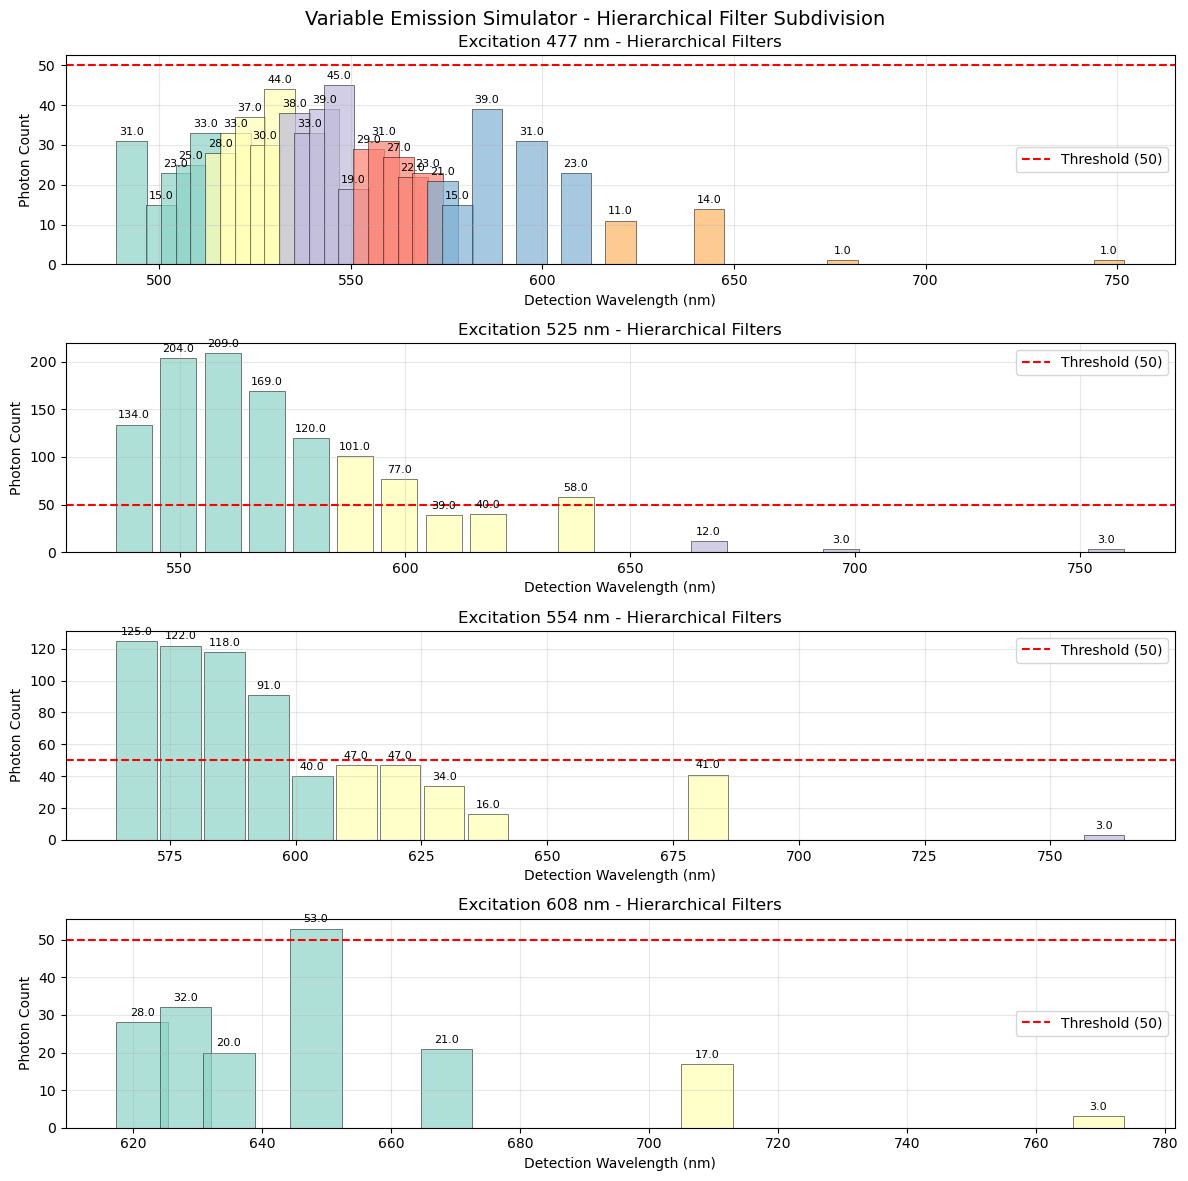

In [106]:
def plot_filter_hierarchy(measurements_dict, excitation_wavelengths, title="Filter Hierarchy"):
    """
    Plot the hierarchical filter structure based on measurements.
    """
    # Extract unique detection wavelengths
    det_wavelengths = sorted(set([det for (exc, det) in measurements_dict.keys()]))
    
    # Create figure
    fig, axes = plt.subplots(len(excitation_wavelengths), 1, figsize=(12, 3*len(excitation_wavelengths)))
    if len(excitation_wavelengths) == 1:
        axes = [axes]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(det_wavelengths)))
    
    for i_exc, exc_wl in enumerate(excitation_wavelengths):
        ax = axes[i_exc]
        
        # Get measurements for this excitation
        exc_measurements = [(det, measurements_dict[(exc_wl, det)]) 
                          for det in det_wavelengths 
                          if (exc_wl, det) in measurements_dict]
        
        det_wls, photon_counts = zip(*exc_measurements)
        
        # Plot bar chart
        bars = ax.bar(det_wls, photon_counts, width=8, alpha=0.7, 
                     color=colors[:len(det_wls)], edgecolor='black', linewidth=0.5)
        
        # Add threshold line
        ax.axhline(y=variable_simulator.threshold, color='red', linestyle='--', 
                  label=f'Threshold ({variable_simulator.threshold})')
        
        # Annotations
        for bar, count in zip(bars, photon_counts):
            height = bar.get_height()
            ax.annotate(f'{count:.1f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
        
        ax.set_xlabel('Detection Wavelength (nm)')
        ax.set_ylabel('Photon Count')
        ax.set_title(f'Excitation {exc_wl} nm - Hierarchical Filters')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot the hierarchical filter structure
plot_filter_hierarchy(
    debug_results['measurements'], 
    excitation_mgr.excitation_wavelengths,
    "Variable Emission Simulator - Hierarchical Filter Subdivision"
)

## 6. Visualize Interpolated Spectrum

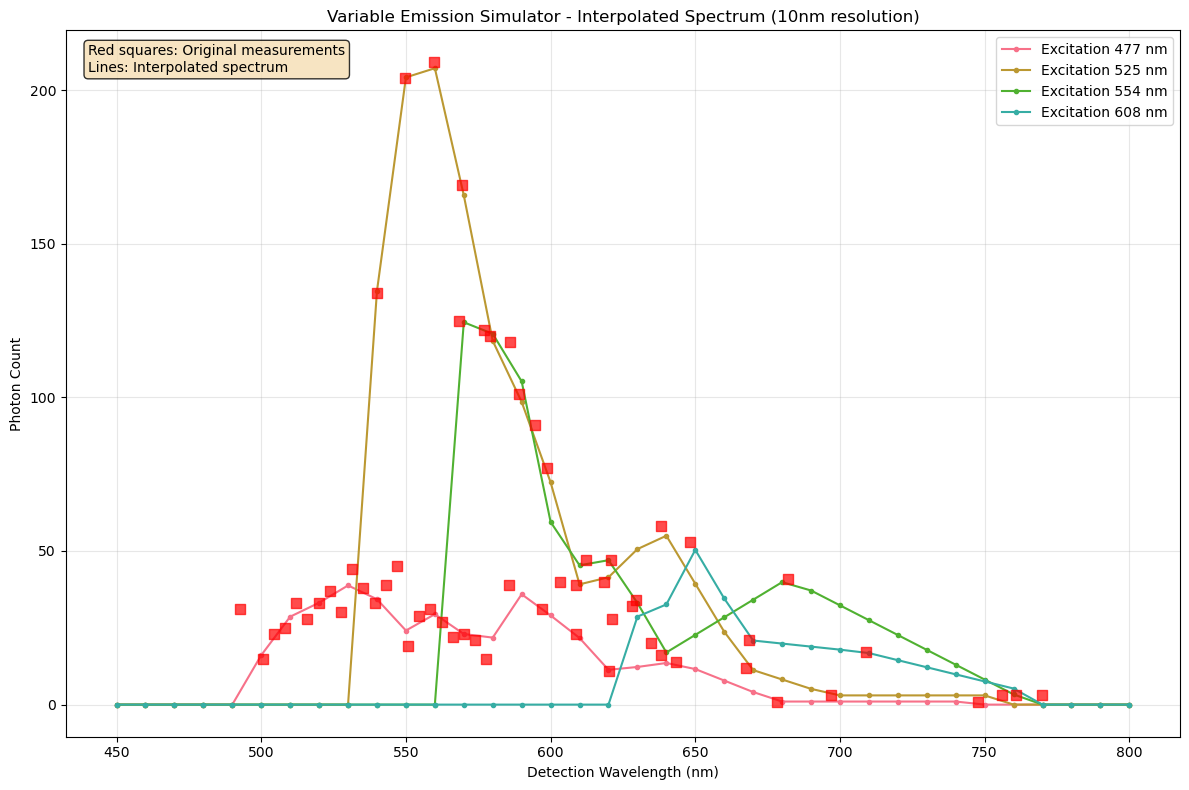

Interpolated spectrum shape: (4, 36)
Wavelength grid: 450 to 800 nm
Resolution: 10 nm
Total measurement points: 60


In [107]:
# Plot the interpolated spectrum
interpolated_spectrum = debug_results['interpolated_spectrum']
wavelength_grid = debug_results['wavelength_grid']
excitation_wavelengths = excitation_mgr.excitation_wavelengths

plt.figure(figsize=(12, 8))

# Plot interpolated spectrum for each excitation
for i_exc, exc_wl in enumerate(excitation_wavelengths):
    plt.plot(wavelength_grid, interpolated_spectrum[i_exc, :], 
             marker='o', markersize=3, label=f'Excitation {exc_wl} nm')

# Add original measurement points
for (exc_wl, det_wl), count in debug_results['measurements'].items():
    plt.scatter(det_wl, count, s=50, marker='s', 
               color='red', alpha=0.7, zorder=5)

plt.xlabel('Detection Wavelength (nm)')
plt.ylabel('Photon Count')
plt.title('Variable Emission Simulator - Interpolated Spectrum (10nm resolution)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text annotation about measurement points
plt.text(0.02, 0.98, 'Red squares: Original measurements\nLines: Interpolated spectrum', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Interpolated spectrum shape: {interpolated_spectrum.shape}")
print(f"Wavelength grid: {wavelength_grid[0]:.0f} to {wavelength_grid[-1]:.0f} nm")
print(f"Resolution: {wavelength_grid[1] - wavelength_grid[0]:.0f} nm")
print(f"Total measurement points: {len(debug_results['measurements'])}")

## 7. Compare with Standard Emission Simulator

Standard simulator output shape: (4, 4)
Variable simulator SBI output shape: (36, 4)


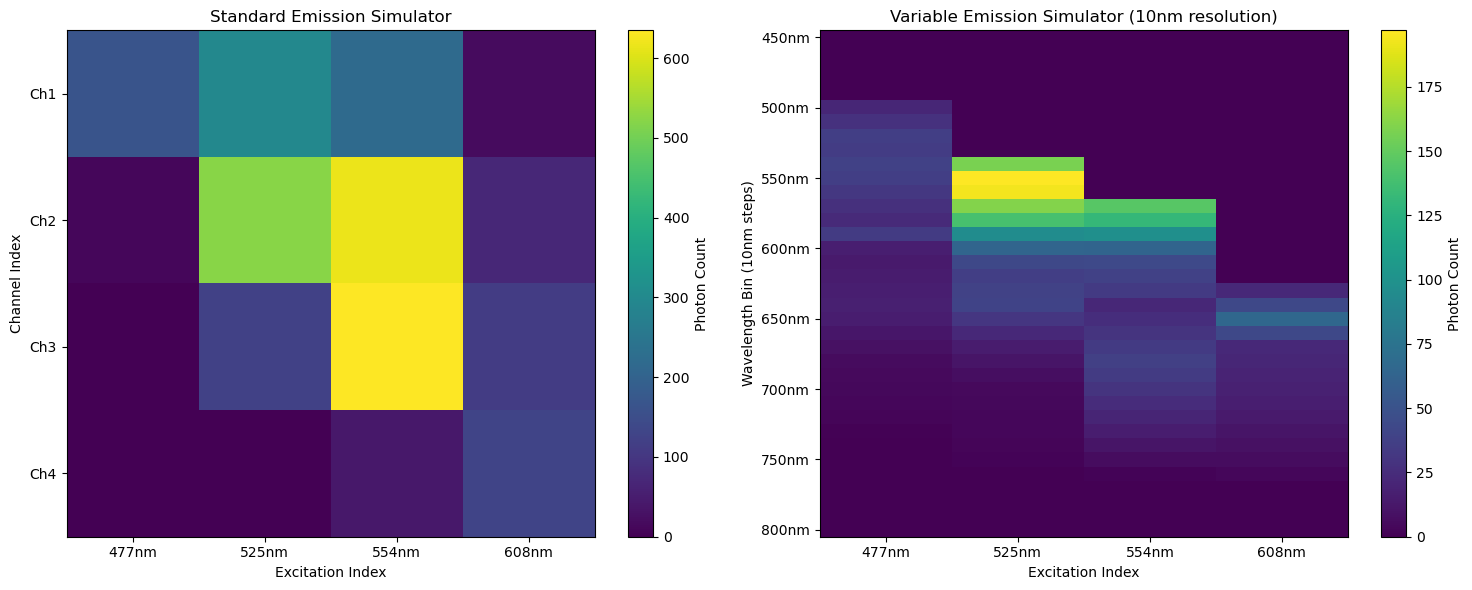

In [108]:
# Run standard simulator for comparison
standard_results = standard_simulator.simulate(
    concentrations=test_concentrations, 
    add_noise=True,
    debug=False
)

# Run variable simulator in normal mode (for SBI compatibility)
variable_results_sbi = variable_simulator.simulate(
    concentrations=test_concentrations, 
    add_noise=True,
    debug=False
)

print(f"Standard simulator output shape: {standard_results.shape}")
print(f"Variable simulator SBI output shape: {variable_results_sbi.shape}")

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Standard simulator heatmap
im1 = ax1.imshow(standard_results, aspect='auto', interpolation='nearest', cmap='viridis')
ax1.set_title('Standard Emission Simulator')
ax1.set_xlabel('Excitation Index')
ax1.set_ylabel('Channel Index')
ax1.set_xticks(range(len(excitation_wavelengths)))
ax1.set_xticklabels([f'{wl}nm' for wl in excitation_wavelengths])
ax1.set_yticks(range(len(standard_filter_cfgs)))
ax1.set_yticklabels([f'Ch{i+1}' for i in range(len(standard_filter_cfgs))])
plt.colorbar(im1, ax=ax1, label='Photon Count')

# Variable simulator heatmap
im2 = ax2.imshow(variable_results_sbi, aspect='auto', interpolation='nearest', cmap='viridis')
ax2.set_title('Variable Emission Simulator (10nm resolution)')
ax2.set_xlabel('Excitation Index')
ax2.set_ylabel('Wavelength Bin (10nm steps)')
ax2.set_xticks(range(len(excitation_wavelengths)))
ax2.set_xticklabels([f'{wl}nm' for wl in excitation_wavelengths])
# Show every 5th wavelength bin
n_bins = variable_results_sbi.shape[0]
tick_indices = range(0, n_bins, 5)
tick_labels = [f'{int(wavelength_grid[i])}nm' for i in tick_indices]
ax2.set_yticks(tick_indices)
ax2.set_yticklabels(tick_labels)
plt.colorbar(im2, ax=ax2, label='Photon Count')

plt.tight_layout()
plt.show()

In [109]:
variable_results_sbi.shape, standard_results.shape
np.sum(variable_results_sbi), np.sum(standard_results)
print(f"Total photon count (Variable): {np.sum(variable_results_sbi)}")
print(f"Total photon count (Standard): {np.sum(standard_results)}")

Total photon count (Variable): 2889.3303017382295
Total photon count (Standard): 2964


## 8. Test Different Threshold Values

Testing different threshold values...
Threshold | Number of Measurements | Total Photons
--------------------------------------------------
Starting simulation with 4 dyes
Excitation wavelengths: [477 525 554 608]
Threshold for subdivision: 5
Minimum filter width: 10 nm

=== Phase 1: Calculate normalization factor ===

Laser 477nm broad filters:
  Filter 1: 477-585 nm
  Filter 2: 585-692 nm
  Filter 3: 692-800 nm
  Photon counts: [2.02399263e+01 2.33456684e+00 1.64678052e-02]

Laser 525nm broad filters:
  Filter 1: 525-617 nm
  Filter 2: 617-708 nm
  Filter 3: 708-800 nm
  Photon counts: [13.9960432   1.69648239  0.05401798]

Laser 554nm broad filters:
  Filter 1: 554-636 nm
  Filter 2: 636-718 nm
  Filter 3: 718-800 nm
  Photon counts: [11.75094525  1.82637681  0.0786019 ]

Laser 608nm broad filters:
  Filter 1: 608-672 nm
  Filter 2: 672-736 nm
  Filter 3: 736-800 nm
  Photon counts: [9.15000251 1.38289552 0.11191882]

Total signal before normalization: 62.638
Normalization factor: 4

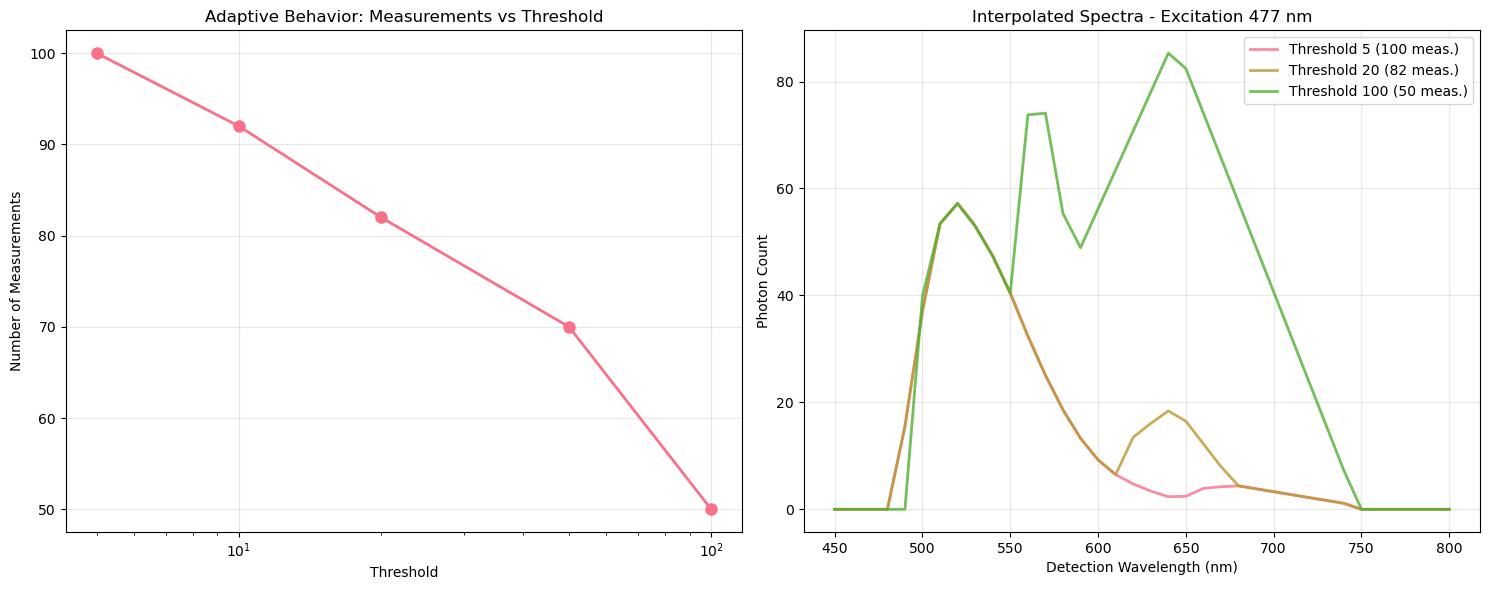

In [93]:
# Test different threshold values
threshold_values = [5, 10, 20, 50, 100]
results_by_threshold = {}

print("Testing different threshold values...")
print("Threshold | Number of Measurements | Total Photons")
print("-" * 50)

for threshold in threshold_values:
    # Create simulator with different threshold
    test_simulator = VariableEmissionSimulator(
        spectra_manager=spectra_mgr,
        filter_bank=initial_filter_bank,
        config=base_cfg,
        excitation_manager=excitation_mgr,
        prior_manager=prior_mgr,
        threshold=threshold,
        min_filter_width=10
    )
    
    # Run simulation
    result = test_simulator.simulate(
        concentrations=test_concentrations,
        add_noise=False,
        debug=True
    )
    
    results_by_threshold[threshold] = result
    n_measurements = len(result['measurements'])
    total_photons = np.sum(result['interpolated_spectrum'])
    
    print(f"{threshold:8d} | {n_measurements:18d} | {total_photons:12.1f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Number of measurements vs threshold
n_measurements_list = [len(results_by_threshold[t]['measurements']) for t in threshold_values]
ax1.plot(threshold_values, n_measurements_list, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Measurements')
ax1.set_title('Adaptive Behavior: Measurements vs Threshold')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Spectrum comparison for different thresholds
for i, threshold in enumerate([5, 20, 100]):
    spectrum = results_by_threshold[threshold]['interpolated_spectrum']
    # Plot first excitation only for clarity
    ax2.plot(wavelength_grid, spectrum[0, :], 
             label=f'Threshold {threshold} ({len(results_by_threshold[threshold]["measurements"])} meas.)',
             alpha=0.8, linewidth=2)

ax2.set_xlabel('Detection Wavelength (nm)')
ax2.set_ylabel('Photon Count')
ax2.set_title(f'Interpolated Spectra - Excitation {excitation_wavelengths[0]} nm')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Visualize Fluorophore Spectra with Adaptive Filters

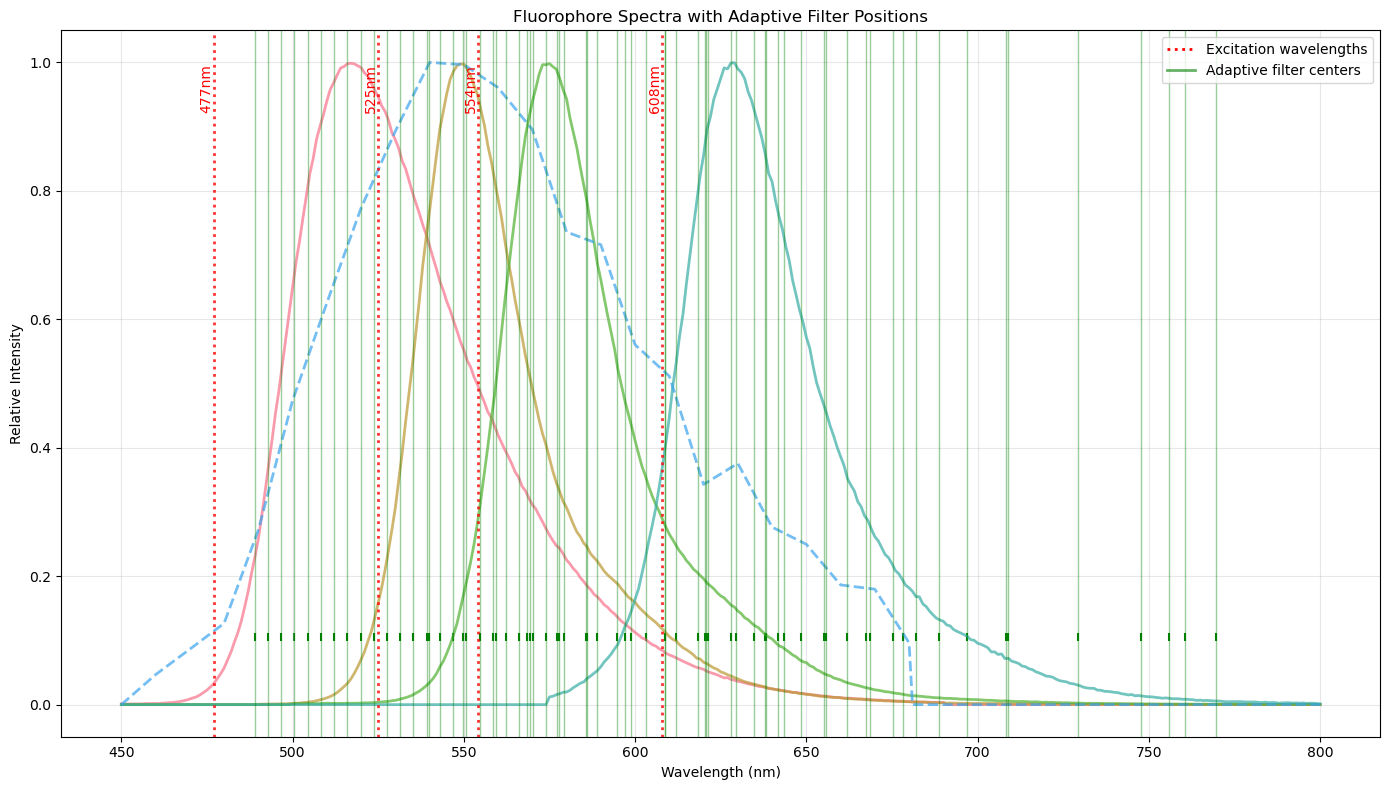

Total adaptive filter positions: 70
Filter positions: [np.float64(488.9320987654321), np.float64(492.7962962962963), np.float64(496.6604938271605), np.float64(500.5246913580247), np.float64(504.3888888888889), np.float64(508.2530864197531), np.float64(512.1172839506173), np.float64(515.9814814814815), np.float64(519.8456790123457), np.float64(523.7098765432099), np.float64(527.5740740740741), np.float64(531.4382716049383), np.float64(535.3024691358025), np.float64(539.1666666666667), np.float64(539.9074074074074), np.float64(543.0308641975308), np.float64(546.895061728395), np.float64(549.7222222222222), np.float64(550.7592592592592), np.float64(554.6234567901234), np.float64(558.4876543209876), np.float64(559.5370370370371), np.float64(562.3518518518518), np.float64(566.216049382716), np.float64(568.3703703703704), np.float64(569.3518518518518), np.float64(570.0802469135803), np.float64(573.9444444444445), np.float64(577.1111111111111), np.float64(577.8086419753087), np.float64(579.16

In [94]:
# Plot fluorophore spectra with adaptive filter positions
wavelengths = spectra_mgr.wavelength_grid

plt.figure(figsize=(14, 8))

# Plot emission spectra
for dye in base_cfg.dye_names:
    emission = spectra_mgr.get_emission(dye)
    plt.plot(wavelengths, emission, label=f'{dye} emission', alpha=0.7, linewidth=2)

# Plot background if present
if base_cfg.bg_dye:
    bg_emission = spectra_mgr.get_emission(base_cfg.bg_dye)
    plt.plot(wavelengths, bg_emission, label=f'{base_cfg.bg_dye} (background)', 
             linestyle='--', alpha=0.7, linewidth=2)

# Plot excitation lines
for exc_wl in excitation_wavelengths:
    plt.axvline(exc_wl, color='red', linestyle=':', alpha=0.8, linewidth=2)
    plt.text(exc_wl, plt.ylim()[1]*0.95, f'{exc_wl}nm', 
             rotation=90, ha='right', va='top', color='red')

# Plot adaptive filter positions
det_wavelengths = sorted(set([det for (exc, det) in debug_results['measurements'].keys()]))
y_max = plt.ylim()[1]

for det_wl in det_wavelengths:
    plt.axvline(det_wl, color='green', linestyle='-', alpha=0.4, linewidth=1)
    plt.scatter(det_wl, y_max*0.1, color='green', s=30, marker='|')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative Intensity')
plt.title('Fluorophore Spectra with Adaptive Filter Positions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add legend for lines
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', linestyle=':', linewidth=2),
                Line2D([0], [0], color='green', linestyle='-', alpha=0.6, linewidth=2)]
plt.legend(custom_lines, ['Excitation wavelengths', 'Adaptive filter centers'], 
          loc='upper right')

plt.tight_layout()
plt.show()

print(f"Total adaptive filter positions: {len(det_wavelengths)}")
print(f"Filter positions: {sorted(det_wavelengths)}")

## 10. Performance Analysis

In [95]:
import time

# Performance comparison
n_runs = 10
print(f"Performance comparison ({n_runs} runs each):")
print("-" * 50)

# Standard simulator timing
start_time = time.time()
for _ in range(n_runs):
    _ = standard_simulator.simulate(test_concentrations, add_noise=False, debug=False)
standard_time = time.time() - start_time

# Variable simulator timing
start_time = time.time()
for _ in range(n_runs):
    _ = variable_simulator.simulate(test_concentrations, add_noise=False, debug=False)
variable_time = time.time() - start_time

print(f"Standard simulator: {standard_time/n_runs*1000:.2f} ms per run")
print(f"Variable simulator: {variable_time/n_runs*1000:.2f} ms per run")
print(f"Slowdown factor: {variable_time/standard_time:.1f}x")

# Output comparison
print(f"\nOutput characteristics:")
print(f"Standard simulator output: {standard_results.shape} ({np.prod(standard_results.shape)} values)")
print(f"Variable simulator output: {variable_results_sbi.shape} ({np.prod(variable_results_sbi.shape)} values)")
print(f"Data expansion factor: {np.prod(variable_results_sbi.shape)/np.prod(standard_results.shape):.1f}x")

# Information content analysis
print(f"\nInformation content analysis:")
print(f"Standard simulator non-zero elements: {np.count_nonzero(standard_results)}")
print(f"Variable simulator non-zero elements: {np.count_nonzero(variable_results_sbi)}")
print(f"Standard simulator entropy: {-np.sum(standard_results * np.log(standard_results + 1e-10)):.2f}")
print(f"Variable simulator entropy: {-np.sum(variable_results_sbi * np.log(variable_results_sbi + 1e-10)):.2f}")

Performance comparison (10 runs each):
--------------------------------------------------
Standard simulator: 0.40 ms per run
Variable simulator: 4.33 ms per run
Slowdown factor: 10.9x

Output characteristics:
Standard simulator output: (4, 4) (16 values)
Variable simulator output: (36, 4) (144 values)
Data expansion factor: 9.0x

Information content analysis:
Standard simulator non-zero elements: 16
Variable simulator non-zero elements: 82
Standard simulator entropy: -17142.74
Variable simulator entropy: -8964.22


## 11. Test with Different Fluorophore Combinations

Starting simulation with 4 dyes
Excitation wavelengths: [477 525 554 608]
Threshold for subdivision: 50
Minimum filter width: 10 nm

=== Phase 1: Calculate normalization factor ===

Laser 477nm broad filters:
  Filter 1: 477-585 nm
  Filter 2: 585-692 nm
  Filter 3: 692-800 nm
  Photon counts: [2.40939642e+01 5.28044521e+00 1.79815498e-02]

Laser 525nm broad filters:
  Filter 1: 525-617 nm
  Filter 2: 617-708 nm
  Filter 3: 708-800 nm
  Photon counts: [18.09306381  2.53050574  0.05912721]

Laser 554nm broad filters:
  Filter 1: 554-636 nm
  Filter 2: 636-718 nm
  Filter 3: 718-800 nm
  Photon counts: [13.63787073  2.24673576  0.08645566]

Laser 608nm broad filters:
  Filter 1: 608-672 nm
  Filter 2: 672-736 nm
  Filter 3: 736-800 nm
  Photon counts: [10.37107983  1.56432981  0.1264484 ]

Total signal before normalization: 78.108
Normalization factor: 38.408

=== Phase 2: Independent laser processing ===

--- Processing Laser 477 nm ---
Initial filter range for laser 477nm: 487-800 nm
 

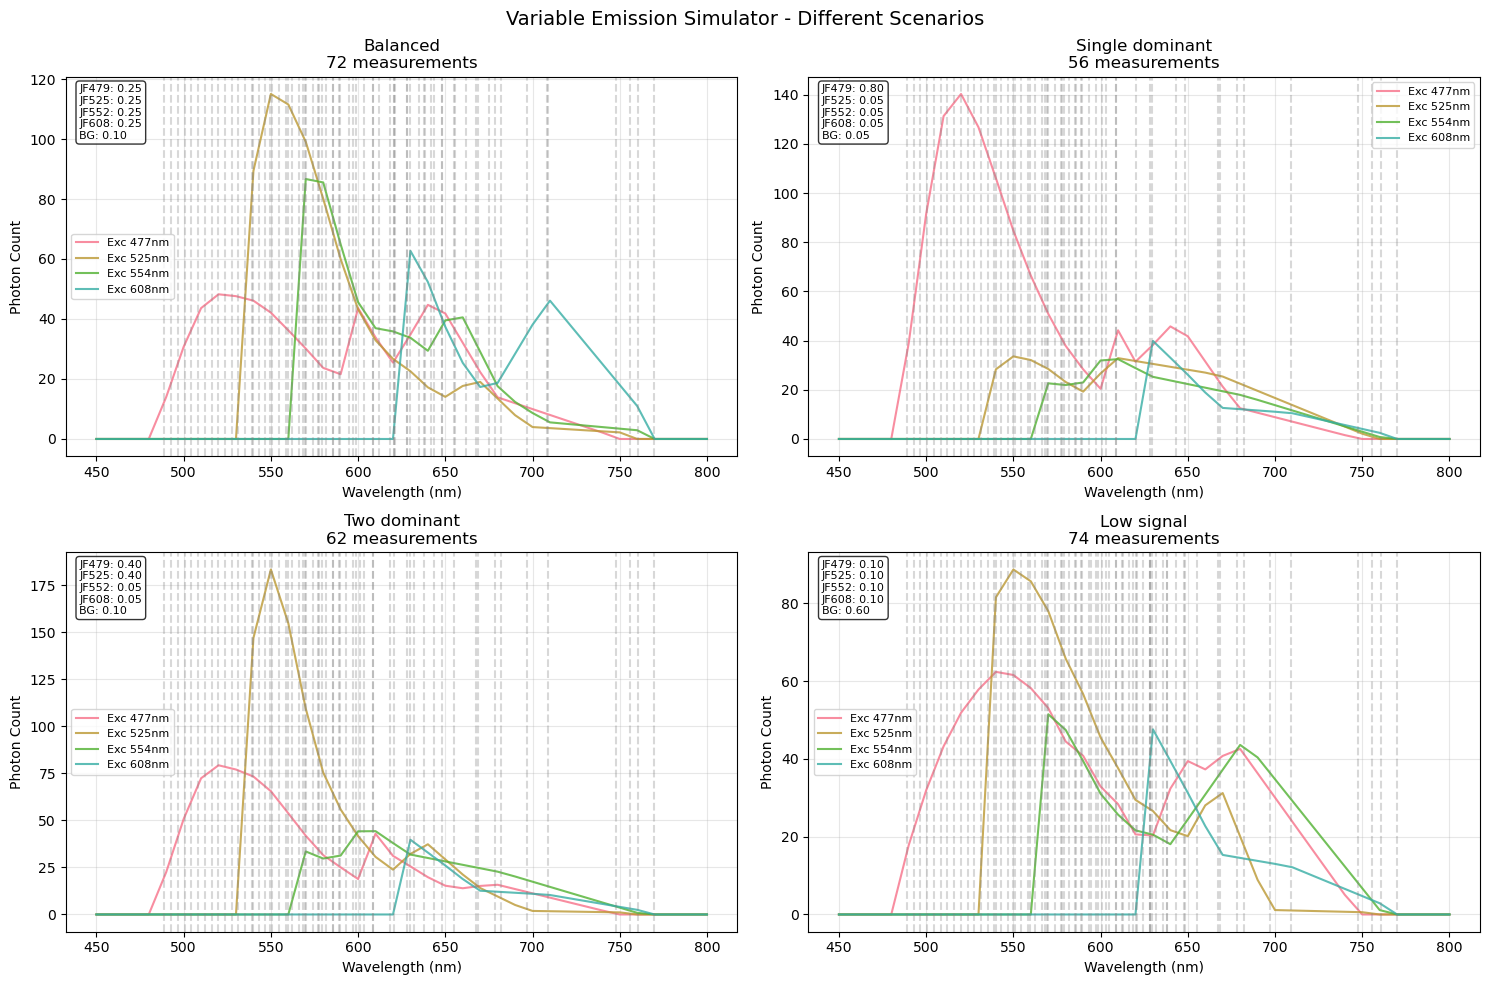

In [96]:
# Test different scenarios
test_scenarios = {
    "Balanced": np.array([0.25, 0.25, 0.25, 0.25, 0.1]),  # Equal concentrations + background
    "Single dominant": np.array([0.8, 0.05, 0.05, 0.05, 0.05]),  # One dye dominates
    "Two dominant": np.array([0.4, 0.4, 0.05, 0.05, 0.1]),  # Two dyes dominate
    "Low signal": np.array([0.1, 0.1, 0.1, 0.1, 0.6]),  # High background
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (scenario_name, concentrations) in enumerate(test_scenarios.items()):
    ax = axes[i]
    
    # Run simulation
    result = variable_simulator.simulate(
        concentrations=concentrations,
        add_noise=False,
        debug=True
    )
    
    # Plot interpolated spectrum
    for j, exc_wl in enumerate(excitation_wavelengths):
        ax.plot(wavelength_grid, result['interpolated_spectrum'][j, :], 
               label=f'Exc {exc_wl}nm', alpha=0.8)
    
    # Mark measurement points
    det_wls = sorted(set([det for (exc, det) in result['measurements'].keys()]))
    for det_wl in det_wls:
        ax.axvline(det_wl, color='gray', alpha=0.3, linestyle='--')
    
    ax.set_title(f'{scenario_name}\n{len(result["measurements"])} measurements')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Photon Count')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add concentration info
    conc_text = "\n".join([f"{dye}: {conc:.2f}" for dye, conc in zip(base_cfg.dye_names, concentrations[:4])])
    conc_text += f"\nBG: {concentrations[4]:.2f}"
    ax.text(0.02, 0.98, conc_text, transform=ax.transAxes, 
           verticalalignment='top', fontsize=8,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Variable Emission Simulator - Different Scenarios', fontsize=14)
plt.tight_layout()
plt.show()

## 12. Summary and Conclusions

In [ ]:
print("=" * 60)
print("VARIABLE EMISSION SIMULATOR - SUMMARY")
print("=" * 60)

print(f"\n📊 CONFIGURATION:")
print(f"  • Fluorophores: {', '.join(base_cfg.dye_names)}")
print(f"  • Background: {base_cfg.bg_dye}")
print(f"  • Excitation wavelengths: {excitation_wavelengths}")
print(f"  • Photon budget: {base_cfg.photon_budget}")
print(f"  • Subdivision threshold: {variable_simulator.threshold}")
print(f"  • Minimum filter width: {variable_simulator.min_filter_width} nm")

print(f"\n🎯 ADAPTIVE BEHAVIOR:")
print(f"  • Initial broad filters: 3 per laser")
print(f"  • Final measurement points: {len(debug_results['measurements'])}")
print(f"  • Output resolution: 10nm ({len(wavelength_grid)} points from {wavelength_grid[0]:.0f}-{wavelength_grid[-1]:.0f} nm)")

print(f"\n⚡ PERFORMANCE:")
print(f"  • Standard simulator: {standard_time/n_runs*1000:.2f} ms/run, {np.prod(standard_results.shape)} outputs")
print(f"  • Variable simulator: {variable_time/n_runs*1000:.2f} ms/run, {np.prod(variable_results_sbi.shape)} outputs")
print(f"  • Slowdown: {variable_time/standard_time:.1f}x")
print(f"  • Data expansion: {np.prod(variable_results_sbi.shape)/np.prod(standard_results.shape):.1f}x")

print(f"\n🔬 KEY FEATURES:")
print(f"  ✓ Hierarchical adaptive filtering")
print(f"  ✓ Laser-specific filter ranges")
print(f"  ✓ Independent per-laser processing")
print(f"  ✓ 10nm interpolated output for SBI compatibility")
print(f"  ✓ Extrapolation to 0 outside measurements")
print(f"  ✓ Uses FilterBank architecture")
print(f"  ✓ Debug mode for detailed analysis")

print(f"\n💡 OBSERVATIONS:")
print(f"  • Lower thresholds → More measurements (higher resolution)")
print(f"  • Threshold {threshold_values[0]} → {n_measurements_list[0]} measurements")
print(f"  • Threshold {threshold_values[-1]} → {n_measurements_list[-1]} measurements")
print(f"  • Adaptive behavior captures spectral features efficiently")
print(f"  • Each laser processes independently")
print(f"  • Output suitable for neural posterior estimation")

print("\n🧠 READY FOR SBI TRAINING!")
print("=" * 60)

## 13. SBI Training Comparison

Now let's train neural posterior estimators using both simulators and compare their performance. This will show how well the hierarchical adaptive filtering approach works for simulation-based inference.

In [110]:
Trainer?

Init signature:
Trainer(
    simulator,
    n_train=2000,
    n_val=500,
    save_dir='sbi_training_demo_results',
)
Docstring:      <no docstring>
Init docstring:
Args:
    simulator: An instance of EmissionSimulator (or compatible simulator)
    n_train: Number of training samples
    n_val: Number of validation samples
    save_dir: Directory to save results
File:           ~/sbi-DELTA/sbi_delta/trainer.py
Type:           type
Subclasses:     

In [ ]:
# Import SBI training components
from sbi_delta.trainer import Trainer
import torch

print("Setting up SBI training for both simulators...")

# Training parameters
n_train = 100000  # Reduced for demo purposes
n_val = 10000
training_params1 = {
    'n_train': n_train,
    'n_val': n_val,
    'save_dir': 'standard_simulator_results'
}

training_params2 = {
    'n_train': n_train,
    'n_val': n_val,
    'save_dir': 'variable_simulator_results'
}
print(f"Training parameters:")
print(f"  • Training samples: {n_train}")
print(f"  • Validation samples: {n_val}")
print(f"  • Save directory: {training_params1['save_dir']}")

# Initialize trainers
print("\nInitializing trainers...")
standard_trainer = Trainer(standard_simulator, **training_params1, )
variable_trainer = Trainer(variable_simulator, **training_params2)

print("✅ Trainers initialized successfully!")
print(f"Standard trainer prior: {standard_trainer.prior}")
print(f"Variable trainer prior: {variable_trainer.prior}")

Setting up SBI training for both simulators...
Training parameters:
  • Training samples: 100000
  • Validation samples: 10000
  • Save directory: standard_simulator_results

Initializing trainers...
✅ Trainers initialized successfully!
Standard trainer prior: JointPrior()
Variable trainer prior: JointPrior()


In [99]:
# Train Standard Simulator
print("=" * 60)
print("TRAINING STANDARD EMISSION SIMULATOR")
print("=" * 60)

import time
start_time = time.time()
standard_posterior = standard_trainer.train()
standard_training_time = time.time() - start_time

print(f"✅ Standard simulator training completed in {standard_training_time:.1f} seconds")
print("Standard posterior trained successfully.")

TRAINING STANDARD EMISSION SIMULATOR
 Neural network successfully converged after 186 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 186
        Best validation performance: -20.0490
        -------------------------
        
✅ Standard simulator training completed in 548.5 seconds
Standard posterior trained successfully.


/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(


In [100]:
# Train Variable Simulator
print("=" * 60)
print("TRAINING VARIABLE EMISSION SIMULATOR")
print("=" * 60)

start_time = time.time()
variable_posterior = variable_trainer.train()
variable_training_time = time.time() - start_time

print(f"✅ Variable simulator training completed in {variable_training_time:.1f} seconds")
print("Variable posterior trained successfully.")

print(f"\n📊 TRAINING TIME COMPARISON:")
print(f"  • Standard simulator: {standard_training_time:.1f} seconds")
print(f"  • Variable simulator: {variable_training_time:.1f} seconds")
print(f"  • Training time ratio: {variable_training_time/standard_training_time:.1f}x")

TRAINING VARIABLE EMISSION SIMULATOR
 Neural network successfully converged after 172 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 172
        Best validation performance: -19.2315
        -------------------------
        
✅ Variable simulator training completed in 935.9 seconds
Variable posterior trained successfully.

📊 TRAINING TIME COMPARISON:
  • Standard simulator: 548.5 seconds
  • Variable simulator: 935.9 seconds
  • Training time ratio: 1.7x


In [101]:
# Validate both models
print("=" * 60)
print("VALIDATION COMPARISON")
print("=" * 60)

# Validate Standard Simulator
print("Validating Standard Emission Simulator...")
standard_r2_scores, standard_rmse_scores, standard_rmse = standard_trainer.validate()
standard_mean_r2 = np.mean(standard_r2_scores)

print(f"Standard Simulator - Mean R²: {standard_mean_r2:.3f}, RMSE: {standard_rmse:.4f}")

# Validate Variable Simulator  
print("Validating Variable Emission Simulator...")
variable_r2_scores, variable_rmse_scores, variable_rmse = variable_trainer.validate()
variable_mean_r2 = np.mean(variable_r2_scores)

print(f"Variable Simulator - Mean R²: {variable_mean_r2:.3f}, RMSE: {variable_rmse:.4f}")

print(f"\n📈 PERFORMANCE COMPARISON:")
print(f"  • Standard R²: {standard_mean_r2:.3f}")
print(f"  • Variable R²: {variable_mean_r2:.3f}")
print(f"  • R² improvement: {((variable_mean_r2 - standard_mean_r2) / standard_mean_r2 * 100):+.1f}%")
print(f"  • Standard RMSE: {standard_rmse:.4f}")
print(f"  • Variable RMSE: {variable_rmse:.4f}")
print(f"  • RMSE improvement: {((standard_rmse - variable_rmse) / standard_rmse * 100):+.1f}%")

# Determine winner
if variable_mean_r2 > standard_mean_r2:
    print(f"\n🏆 WINNER: Variable Emission Simulator!")
    print(f"   Better R² by {(variable_mean_r2 - standard_mean_r2):.3f}")
else:
    print(f"\n🏆 WINNER: Standard Emission Simulator!")
    print(f"   Better R² by {(standard_mean_r2 - variable_mean_r2):.3f}")

VALIDATION COMPARISON
Validating Standard Emission Simulator...


Validating: 100%|██████████| 10000/10000 [02:53<00:00, 57.58it/s]


Validation mean R^2: 0.985, RMSE: 0.0109
Standard Simulator - Mean R²: 0.985, RMSE: 0.0109
Validating Variable Emission Simulator...


Validating: 100%|██████████| 10000/10000 [02:51<00:00, 58.47it/s]


Validation mean R^2: 0.981, RMSE: 0.0126
Variable Simulator - Mean R²: 0.981, RMSE: 0.0126

📈 PERFORMANCE COMPARISON:
  • Standard R²: 0.985
  • Variable R²: 0.981
  • R² improvement: -0.4%
  • Standard RMSE: 0.0109
  • Variable RMSE: 0.0126
  • RMSE improvement: -15.4%

🏆 WINNER: Standard Emission Simulator!
   Better R² by 0.004


## 15. Prediction Quality Analysis

/tmp/ipykernel_2088554/2839913936.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1,1].boxplot(box_data, labels=box_labels, patch_artist=True)


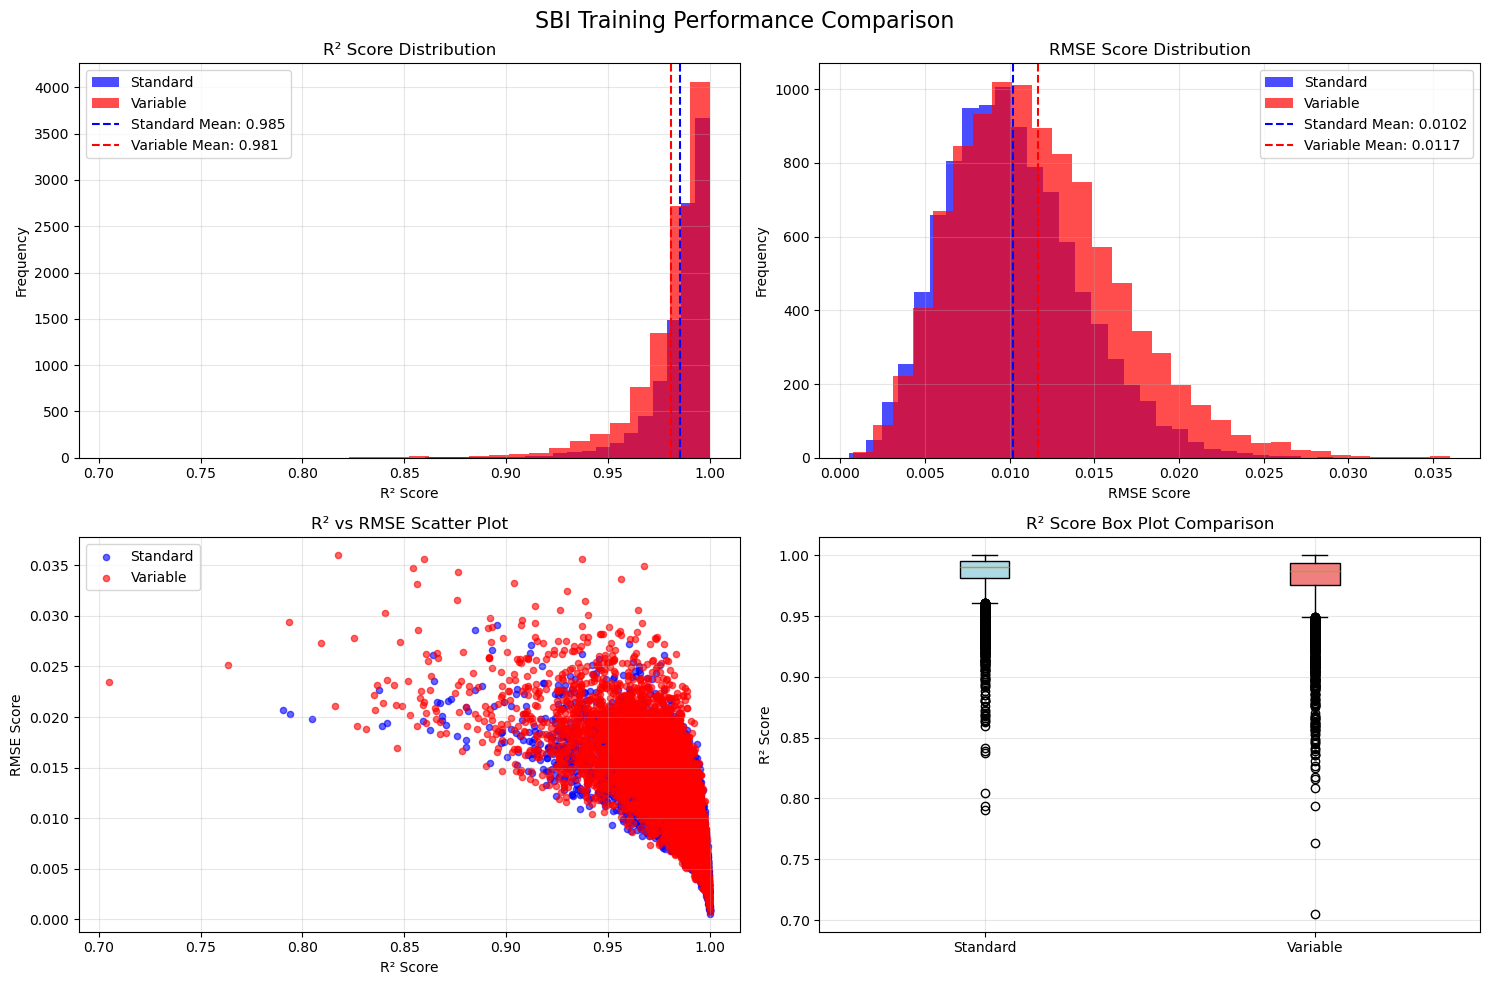

📊 Statistical Summary:
Standard R² - Mean: 0.985, Std: 0.016
Variable R² - Mean: 0.981, Std: 0.020
Standard RMSE - Mean: 0.0102, Std: 0.0040
Variable RMSE - Mean: 0.0117, Std: 0.0048


In [102]:
# Plot validation comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² comparison
axes[0,0].hist(standard_r2_scores, bins=30, alpha=0.7, label='Standard', color='blue')
axes[0,0].hist(variable_r2_scores, bins=30, alpha=0.7, label='Variable', color='red')
axes[0,0].axvline(standard_mean_r2, color='blue', linestyle='--', label=f'Standard Mean: {standard_mean_r2:.3f}')
axes[0,0].axvline(variable_mean_r2, color='red', linestyle='--', label=f'Variable Mean: {variable_mean_r2:.3f}')
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('R² Score Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# RMSE comparison
axes[0,1].hist(standard_rmse_scores, bins=30, alpha=0.7, label='Standard', color='blue')
axes[0,1].hist(variable_rmse_scores, bins=30, alpha=0.7, label='Variable', color='red')
axes[0,1].axvline(np.mean(standard_rmse_scores), color='blue', linestyle='--', label=f'Standard Mean: {np.mean(standard_rmse_scores):.4f}')
axes[0,1].axvline(np.mean(variable_rmse_scores), color='red', linestyle='--', label=f'Variable Mean: {np.mean(variable_rmse_scores):.4f}')
axes[0,1].set_xlabel('RMSE Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('RMSE Score Distribution')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Scatter plot: R² vs RMSE
axes[1,0].scatter(standard_r2_scores, standard_rmse_scores, alpha=0.6, label='Standard', color='blue', s=20)
axes[1,0].scatter(variable_r2_scores, variable_rmse_scores, alpha=0.6, label='Variable', color='red', s=20)
axes[1,0].set_xlabel('R² Score')
axes[1,0].set_ylabel('RMSE Score')
axes[1,0].set_title('R² vs RMSE Scatter Plot')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Box plot comparison
box_data = [standard_r2_scores, variable_r2_scores]
box_labels = ['Standard', 'Variable']
bp = axes[1,1].boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1,1].set_ylabel('R² Score')
axes[1,1].set_title('R² Score Box Plot Comparison')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('SBI Training Performance Comparison', fontsize=16)
plt.tight_layout()
plt.show()

print("📊 Statistical Summary:")
print(f"Standard R² - Mean: {np.mean(standard_r2_scores):.3f}, Std: {np.std(standard_r2_scores):.3f}")
print(f"Variable R² - Mean: {np.mean(variable_r2_scores):.3f}, Std: {np.std(variable_r2_scores):.3f}")
print(f"Standard RMSE - Mean: {np.mean(standard_rmse_scores):.4f}, Std: {np.std(standard_rmse_scores):.4f}")  
print(f"Variable RMSE - Mean: {np.mean(variable_rmse_scores):.4f}, Std: {np.std(variable_rmse_scores):.4f}")

## 16. Final Summary and Conclusions

📈 Analyzing prediction quality for both simulators...

=== Standard Simulator Predictions ===

=== Variable Simulator Predictions ===


array([<Axes: title={'center': 'Per-example R^2'}, xlabel='R^2 Score', ylabel='Count'>,
       <Axes: title={'center': 'Per-example RMSE'}, xlabel='RMSE', ylabel='Count'>],
      dtype=object)

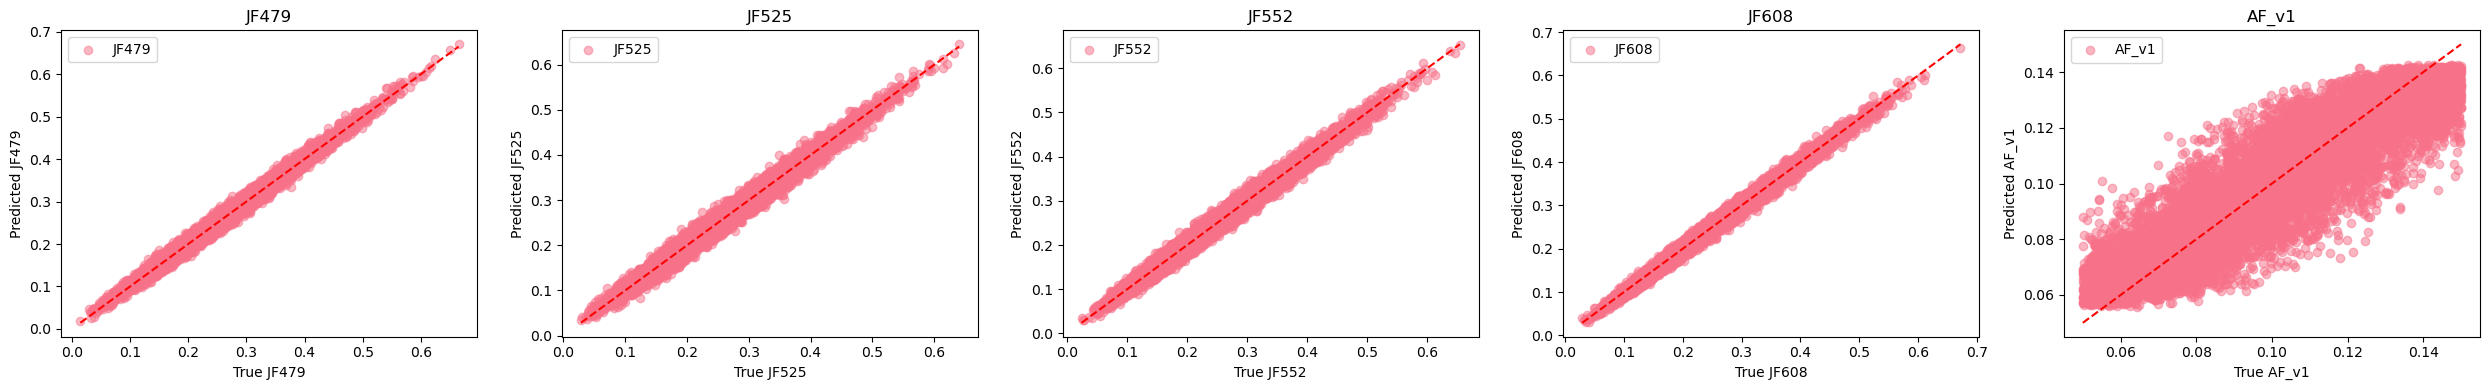

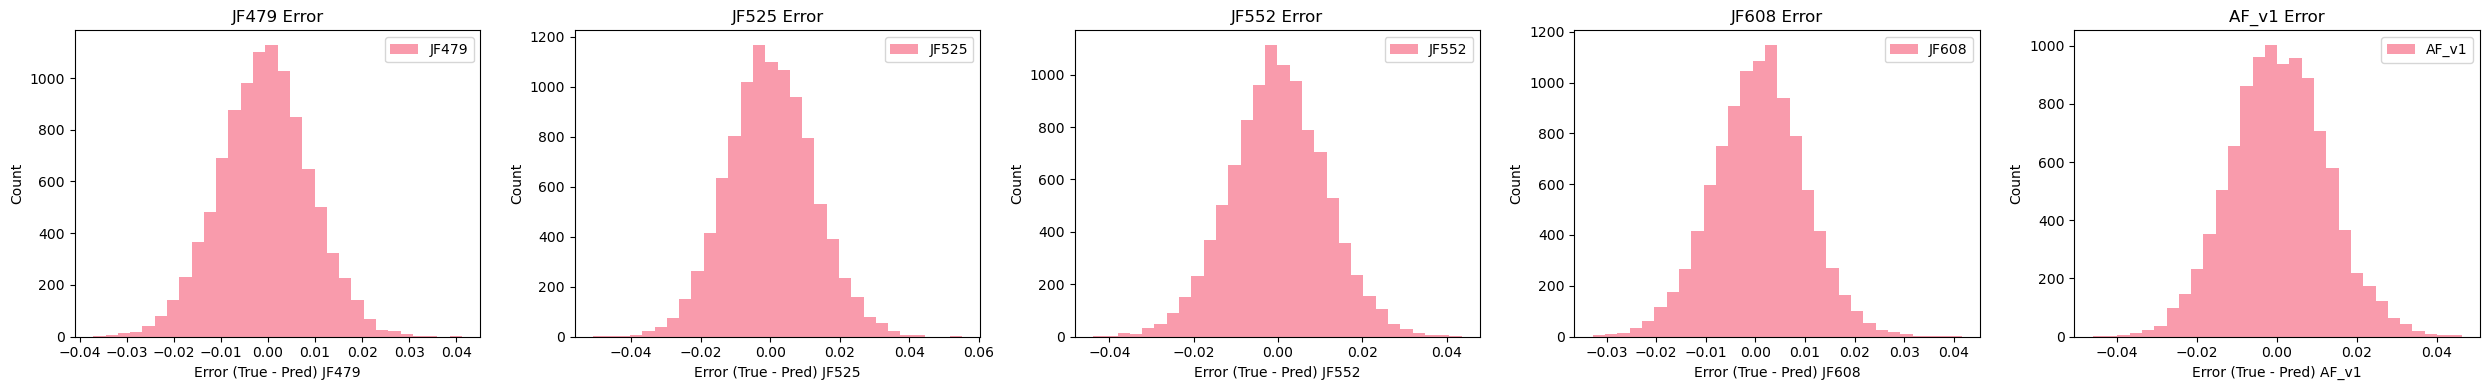

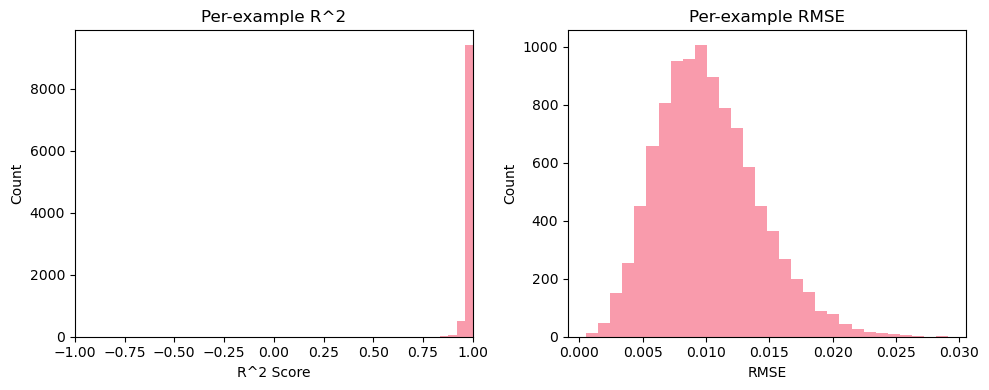

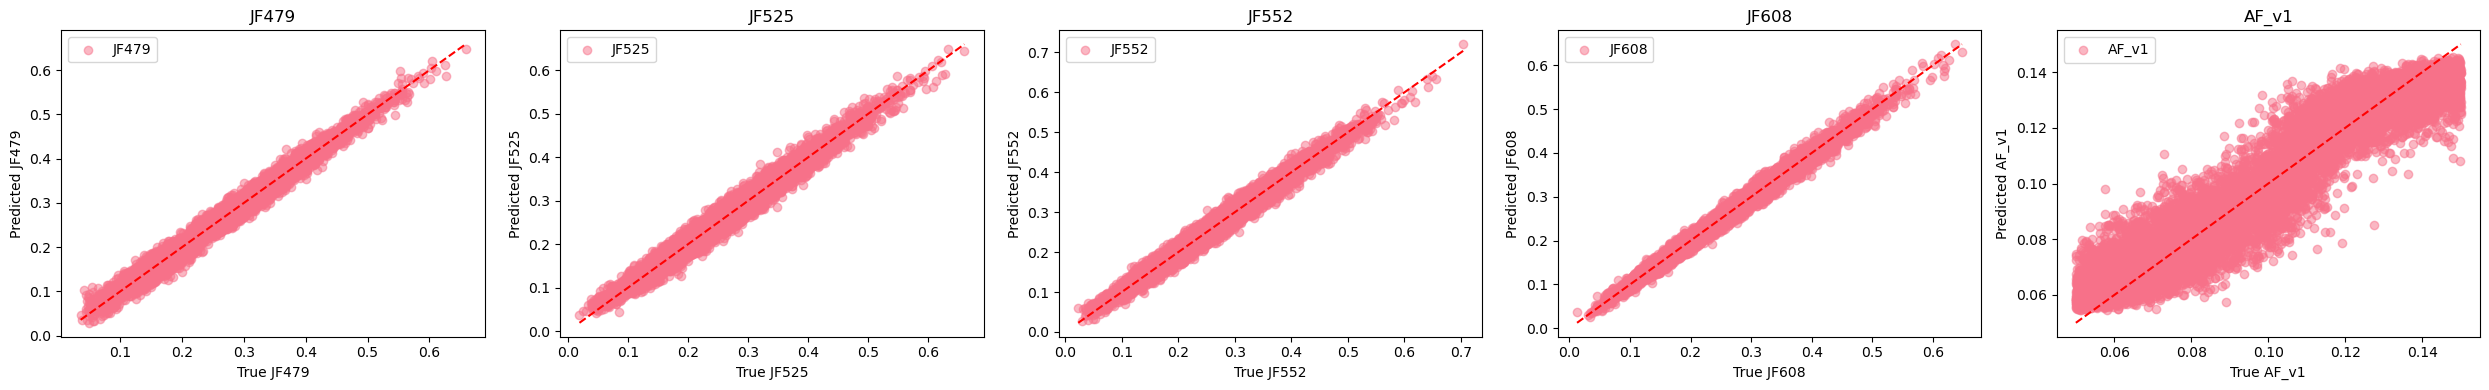

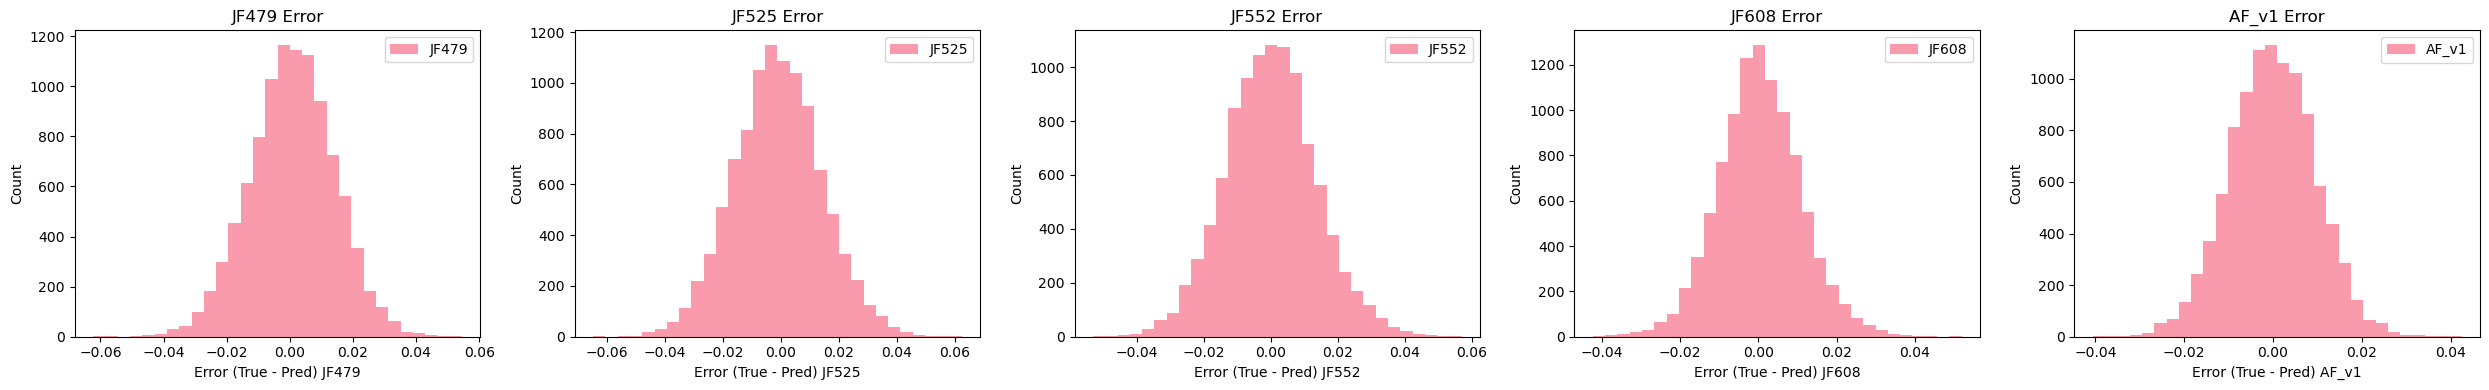

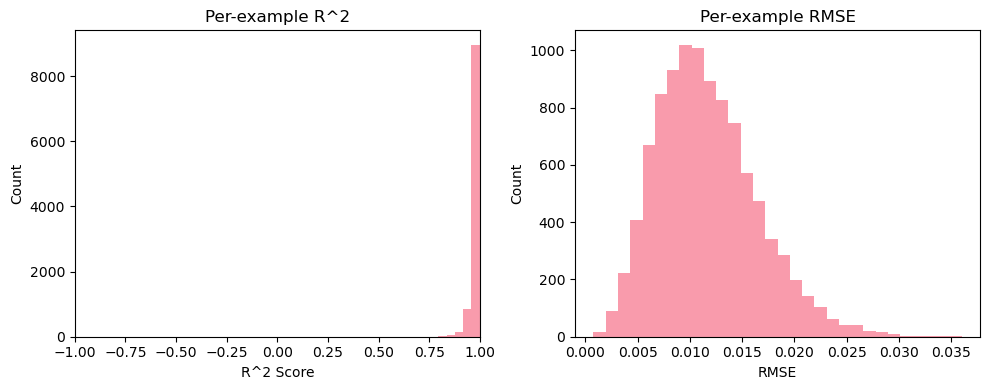

In [103]:
# Plot prediction quality using trainer's built-in methods
print("📈 Analyzing prediction quality for both simulators...")

# Standard simulator prediction plots  
print("\n=== Standard Simulator Predictions ===")
standard_trainer.plot_pred_vs_true()
standard_trainer.plot_error_histograms()
standard_trainer.plot_r2_rmse_distributions()

# Variable simulator prediction plots
print("\n=== Variable Simulator Predictions ===")
variable_trainer.plot_pred_vs_true()
variable_trainer.plot_error_histograms()  
variable_trainer.plot_r2_rmse_distributions()